In [1]:
import pickle
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorchtools
import glob as gl
import random
import os
import time
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import make_regression
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import log_loss
from numpy import hstack
from numpy import vstack

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# Function for saving and loading of training history
def save_data(D3_array, filename):
    with open(filename,"wb") as dat_:
        pickle.dump(D3_array,dat_)
        
def load_data(filename):
    with open(filename,"rb") as ld:
        x_temp = pickle.load(ld)
    return x_temp

In [4]:
def find_directory(foldername, filename = None, back_num = 0):
    cur = os.getcwd()
    for i in range(back_num):
        cur = os.path.abspath(os.path.join(cur, os.pardir))
    for folder in foldername:
        cur = os.path.join(cur, folder)
    if not os.path.exists(cur):
        os.makedirs(cur)
        print(f'{cur} created')
    if filename != None:
        cur = os.path.join(cur, filename)
    return cur

## Linear attention case (RNN-RNN)

In [2]:
def history_state_dict_add(num_cycles, modelname, n_ep, patience, rnn1, layer1, hid1, rnn2, layer2, hid2, lr):
    history_add = find_directory(back_num = 0, foldername = [f'{num_cycles} cycles', f'Depth Test_col_{n_ep}_{patience}', modelname, f'{rnn1}_{rnn2}', 'train_history'], 
                                             filename = f'{rnn1}_{layer1} layers_{hid1}_{rnn2}_{layer2} layers_{hid2}_lr_1_{int(1/lr)}.pkl')
    state_dict_add = find_directory(back_num = 0, foldername = [f'{num_cycles} cycles', f'Depth Test_col_{n_ep}_{patience}', modelname, f'{rnn1}_{rnn2}', 'model'], 
                                             filename = f'{rnn1}_{layer1} layers_{hid1}_{rnn2}_{layer2} layers_{hid2}_lr_1_{int(1/lr)}_state_dict.pth')
    ta_weight_add = find_directory(back_num = 0, foldername = [f'{num_cycles} cycles', f'Depth Test_col_{n_ep}_{patience}', modelname, f'{rnn1}_{rnn2}', 'ta_weight'],
                                             filename = f'{rnn1}_{layer1} layers_{hid1}_{rnn2}_{layer2} layers_{hid2}_lr_1_{int(1/lr)}_ta.wb')
    ca_weight_add = find_directory(back_num = 0, foldername = [f'{num_cycles} cycles', f'Depth Test_col_{n_ep}_{patience}', modelname, f'{rnn1}_{rnn2}', 'ca_weight'],
                                             filename = f'{rnn1}_{layer1} layers_{hid1}_{rnn2}_{layer2} layers_{hid2}_lr_1_{int(1/lr)}_ca.wb')
    return history_add, state_dict_add, ta_weight_add, ca_weight_add

In [14]:
epochs = np.linspace(50, 1000, 20)
n_ep = int(epochs[-1])
# n_ep = 2

modelname = 'RNN_TA_RNN_CA'
rnns = ['BiLSTM', 'BiGRU', 'BiRNN']
hids = [3, 5, 7]
num_cycles = 100
ep_pats = [[3000, 300]]
layer1s = [2, 1]
layer2s = [2, 1]
lrs = [1e-4, 1e-3, 1e-2]
mids = [8, 4, 1]

for [n_ep, patience] in ep_pats:
    for rnn1, rnn2 in itertools.product(rnns, rnns):
        df = pd.DataFrame(columns = ['train rmse', 'val rmse', 'test rmse'])
        for hid1, hid2 in itertools.product(hids, hids):
            for layer1, layer2 in itertools.product(layer1s, layer2s):
                    for lr in lrs:
#                         print(f"{rnn1}-layer1: {layer1}-hid1: {hid1}-{rnn2}-layer2: {layer2}-hid2: {hid2}, lr = {lr}")
                        history_add, _, _, ca_weight_add = history_state_dict_add(num_cycles, modelname, n_ep, patience,
                                                                                rnn1, layer1, hid1, rnn2, layer2, hid2, lr)
                        history = load_data(history_add)
                        
                        df.loc[f'{rnn1}_{hid1}_{layer1}_{rnn2}_{hid2}_{layer2}_{lr}'] = [history.iloc[-1, 0], history.iloc[-1, 1], history.iloc[-1, 2]]
#                         print(history.iloc[-1, :])
#                         ca = load_data(ca_weight_add)
#                         ca = ca.detach().cpu().numpy()
#                         print(ca.shape)
#                         plt.imshow(ca, aspect = 10, cmap = cm.gray)
#                         plt.colorbar()
#                         plt.show()
#                         break

            df

,train rmse,val rmse,test rmse
BiLSTM_3_2_BiLSTM_3_2_0.0001,254.542755,177.835983,114.885818
BiLSTM_3_2_BiLSTM_3_2_0.001,130.228165,91.298729,83.683434
BiLSTM_3_2_BiLSTM_3_2_0.01,223.159286,152.340271,165.803711
BiLSTM_3_2_BiLSTM_3_1_0.0001,286.460144,200.282745,159.760529
BiLSTM_3_2_BiLSTM_3_1_0.001,275.550171,201.372864,159.256012
BiLSTM_3_2_BiLSTM_3_1_0.01,186.799271,137.533447,154.184326
BiLSTM_3_1_BiLSTM_3_2_0.0001,286.460602,200.282928,159.761108
BiLSTM_3_1_BiLSTM_3_2_0.001,275.552399,201.376648,159.254639
BiLSTM_3_1_BiLSTM_3_2_0.01,288.827850,200.104263,156.218536
BiLSTM_3_1_BiLSTM_3_1_0.0001,577.049011,531.268311,524.928345


,train rmse,val rmse,test rmse
BiLSTM_3_2_BiLSTM_3_2_0.0001,254.542755,177.835983,114.885818
BiLSTM_3_2_BiLSTM_3_2_0.001,130.228165,91.298729,83.683434
BiLSTM_3_2_BiLSTM_3_2_0.01,223.159286,152.340271,165.803711
BiLSTM_3_2_BiLSTM_3_1_0.0001,286.460144,200.282745,159.760529
BiLSTM_3_2_BiLSTM_3_1_0.001,275.550171,201.372864,159.256012
BiLSTM_3_2_BiLSTM_3_1_0.01,186.799271,137.533447,154.184326
BiLSTM_3_1_BiLSTM_3_2_0.0001,286.460602,200.282928,159.761108
BiLSTM_3_1_BiLSTM_3_2_0.001,275.552399,201.376648,159.254639
BiLSTM_3_1_BiLSTM_3_2_0.01,288.827850,200.104263,156.218536
BiLSTM_3_1_BiLSTM_3_1_0.0001,577.049011,531.268311,524.928345


,train rmse,val rmse,test rmse
BiLSTM_3_2_BiLSTM_3_2_0.0001,254.542755,177.835983,114.885818
BiLSTM_3_2_BiLSTM_3_2_0.001,130.228165,91.298729,83.683434
BiLSTM_3_2_BiLSTM_3_2_0.01,223.159286,152.340271,165.803711
BiLSTM_3_2_BiLSTM_3_1_0.0001,286.460144,200.282745,159.760529
BiLSTM_3_2_BiLSTM_3_1_0.001,275.550171,201.372864,159.256012
BiLSTM_3_2_BiLSTM_3_1_0.01,186.799271,137.533447,154.184326
BiLSTM_3_1_BiLSTM_3_2_0.0001,286.460602,200.282928,159.761108
BiLSTM_3_1_BiLSTM_3_2_0.001,275.552399,201.376648,159.254639
BiLSTM_3_1_BiLSTM_3_2_0.01,288.827850,200.104263,156.218536
BiLSTM_3_1_BiLSTM_3_1_0.0001,577.049011,531.268311,524.928345


,train rmse,val rmse,test rmse
BiLSTM_3_2_BiLSTM_3_2_0.0001,254.542755,177.835983,114.885818
BiLSTM_3_2_BiLSTM_3_2_0.001,130.228165,91.298729,83.683434
BiLSTM_3_2_BiLSTM_3_2_0.01,223.159286,152.340271,165.803711
BiLSTM_3_2_BiLSTM_3_1_0.0001,286.460144,200.282745,159.760529
BiLSTM_3_2_BiLSTM_3_1_0.001,275.550171,201.372864,159.256012
BiLSTM_3_2_BiLSTM_3_1_0.01,186.799271,137.533447,154.184326
BiLSTM_3_1_BiLSTM_3_2_0.0001,286.460602,200.282928,159.761108
BiLSTM_3_1_BiLSTM_3_2_0.001,275.552399,201.376648,159.254639
BiLSTM_3_1_BiLSTM_3_2_0.01,288.827850,200.104263,156.218536
BiLSTM_3_1_BiLSTM_3_1_0.0001,577.049011,531.268311,524.928345


,train rmse,val rmse,test rmse
BiLSTM_3_2_BiLSTM_3_2_0.0001,254.542755,177.835983,114.885818
BiLSTM_3_2_BiLSTM_3_2_0.001,130.228165,91.298729,83.683434
BiLSTM_3_2_BiLSTM_3_2_0.01,223.159286,152.340271,165.803711
BiLSTM_3_2_BiLSTM_3_1_0.0001,286.460144,200.282745,159.760529
BiLSTM_3_2_BiLSTM_3_1_0.001,275.550171,201.372864,159.256012
BiLSTM_3_2_BiLSTM_3_1_0.01,186.799271,137.533447,154.184326
BiLSTM_3_1_BiLSTM_3_2_0.0001,286.460602,200.282928,159.761108
BiLSTM_3_1_BiLSTM_3_2_0.001,275.552399,201.376648,159.254639
BiLSTM_3_1_BiLSTM_3_2_0.01,288.827850,200.104263,156.218536
BiLSTM_3_1_BiLSTM_3_1_0.0001,577.049011,531.268311,524.928345


,train rmse,val rmse,test rmse
BiLSTM_3_2_BiLSTM_3_2_0.0001,254.542755,177.835983,114.885818
BiLSTM_3_2_BiLSTM_3_2_0.001,130.228165,91.298729,83.683434
BiLSTM_3_2_BiLSTM_3_2_0.01,223.159286,152.340271,165.803711
BiLSTM_3_2_BiLSTM_3_1_0.0001,286.460144,200.282745,159.760529
BiLSTM_3_2_BiLSTM_3_1_0.001,275.550171,201.372864,159.256012
...,...,...,...
BiLSTM_5_1_BiLSTM_7_2_0.001,206.527405,150.102859,114.095734
BiLSTM_5_1_BiLSTM_7_2_0.01,228.974915,138.545364,134.175781
BiLSTM_5_1_BiLSTM_7_1_0.0001,288.502747,200.174789,156.450378
BiLSTM_5_1_BiLSTM_7_1_0.001,288.351410,200.256409,156.893799


,train rmse,val rmse,test rmse
BiLSTM_3_2_BiLSTM_3_2_0.0001,254.542755,177.835983,114.885818
BiLSTM_3_2_BiLSTM_3_2_0.001,130.228165,91.298729,83.683434
BiLSTM_3_2_BiLSTM_3_2_0.01,223.159286,152.340271,165.803711
BiLSTM_3_2_BiLSTM_3_1_0.0001,286.460144,200.282745,159.760529
BiLSTM_3_2_BiLSTM_3_1_0.001,275.550171,201.372864,159.256012
...,...,...,...
BiLSTM_7_1_BiLSTM_3_2_0.001,225.931274,131.171310,101.240250
BiLSTM_7_1_BiLSTM_3_2_0.01,289.030029,200.102493,156.227631
BiLSTM_7_1_BiLSTM_3_1_0.0001,577.431091,531.690125,525.348083
BiLSTM_7_1_BiLSTM_3_1_0.001,554.592529,513.227356,504.317413


,train rmse,val rmse,test rmse
BiLSTM_3_2_BiLSTM_3_2_0.0001,254.542755,177.835983,114.885818
BiLSTM_3_2_BiLSTM_3_2_0.001,130.228165,91.298729,83.683434
BiLSTM_3_2_BiLSTM_3_2_0.01,223.159286,152.340271,165.803711
BiLSTM_3_2_BiLSTM_3_1_0.0001,286.460144,200.282745,159.760529
BiLSTM_3_2_BiLSTM_3_1_0.001,275.550171,201.372864,159.256012
...,...,...,...
BiLSTM_7_1_BiLSTM_5_2_0.001,288.251038,200.101242,156.235504
BiLSTM_7_1_BiLSTM_5_2_0.01,202.159637,142.693359,126.274323
BiLSTM_7_1_BiLSTM_5_1_0.0001,286.259186,200.262054,159.381226
BiLSTM_7_1_BiLSTM_5_1_0.001,109.152969,112.647644,95.305504


,train rmse,val rmse,test rmse
BiLSTM_3_2_BiLSTM_3_2_0.0001,254.542755,177.835983,114.885818
BiLSTM_3_2_BiLSTM_3_2_0.001,130.228165,91.298729,83.683434
BiLSTM_3_2_BiLSTM_3_2_0.01,223.159286,152.340271,165.803711
BiLSTM_3_2_BiLSTM_3_1_0.0001,286.460144,200.282745,159.760529
BiLSTM_3_2_BiLSTM_3_1_0.001,275.550171,201.372864,159.256012
...,...,...,...
BiLSTM_7_1_BiLSTM_7_2_0.001,289.263947,201.461426,159.145905
BiLSTM_7_1_BiLSTM_7_2_0.01,237.522293,164.948486,131.218018
BiLSTM_7_1_BiLSTM_7_1_0.0001,286.298279,200.518066,159.374863
BiLSTM_7_1_BiLSTM_7_1_0.001,275.558197,201.340637,159.267334


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\User\\Desktop\\LIB\\CNN work\\Variable time length\\All dataset\\100 cycles\\Depth Test_col_3000_300\\RNN_TA_RNN_CA\\BiLSTM_BiGRU\\train_history\\BiLSTM_1 layers_3_BiGRU_2 layers_3_lr_1_100.pkl'

In [10]:
history.iloc[-1, :]

train_rmse    577.431091
val_rmse      531.690125
test_rmse     525.348083
Name: 250, dtype: float32

## Self-attention case(230422, RNN-TA-CA-1DCNN)

In [2]:
def history_state_dict_add(num_cycles, modelname, n_ep, patience, rnn1, hid1, nh2, fil2, pool2, npool2, fsize2, psize2, lr):
    history_add = find_directory(back_num = 0, foldername = [f'{num_cycles} cycles', f'Depth Test_col_{n_ep}_{patience}', modelname, f'{rnn1}_1D CNN', 'train_history'], 
                                             filename = f'{rnn1}_hidden_{hid1}_nh_{nh2}_n_fil_{fil2}_pool_{pool2}_npool_{npool2}_fsize_{fsize2}_psize_{psize2}_lr_1_{int(1/lr)}.pkl')
    state_dict_add = find_directory(back_num = 0, foldername = [f'{num_cycles} cycles', f'Depth Test_col_{n_ep}_{patience}', modelname, f'{rnn1}_1D CNN', 'model'], 
                                             filename = f'{rnn1}_hidden_{hid1}_nh_{nh2}_n_fil_{fil2}_pool_{pool2}_npool_{npool2}_fsize_{fsize2}_psize_{psize2}_lr_1_{int(1/lr)}_state_dict.pth')
    ta_add = find_directory(back_num = 0, foldername = [f'{num_cycles} cycles', f'Depth Test_col_{n_ep}_{patience}', modelname, f'{rnn1}_1D CNN', 'ta'],
                                             filename = f'{rnn1}_hidden_{hid1}_nh_{nh2}_n_fil_{fil2}_pool_{pool2}_npool_{npool2}_fsize_{fsize2}_psize_{psize2}_lr_1_{int(1/lr)}_ta.wb')
    ca_add = find_directory(back_num = 0, foldername = [f'{num_cycles} cycles', f'Depth Test_col_{n_ep}_{patience}', modelname, f'{rnn1}_1D CNN', 'ca'],
                                             filename = f'{rnn1}_hidden_{hid1}_nh_{nh2}_n_fil_{fil2}_pool_{pool2}_npool_{npool2}_fsize_{fsize2}_psize_{psize2}_lr_1_{int(1/lr)}_ta.wb')
    return history_add, state_dict_add, ta_add, ca_add

### Best case에 대해서만 ca plot?

epoch: 1000, patience = 10, rnn1 = LSTM, hid1 = 3


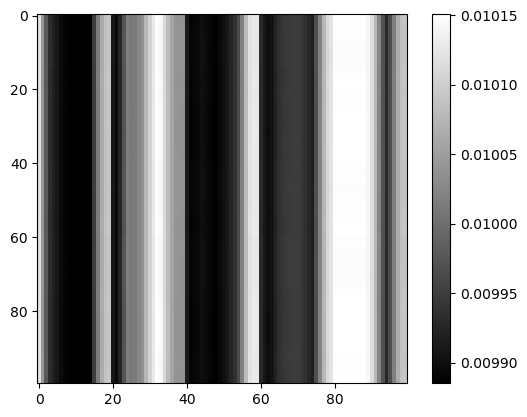

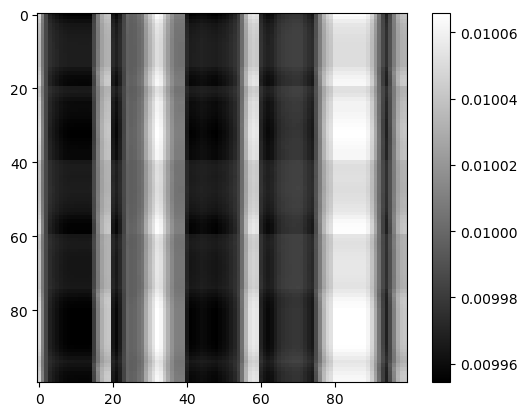

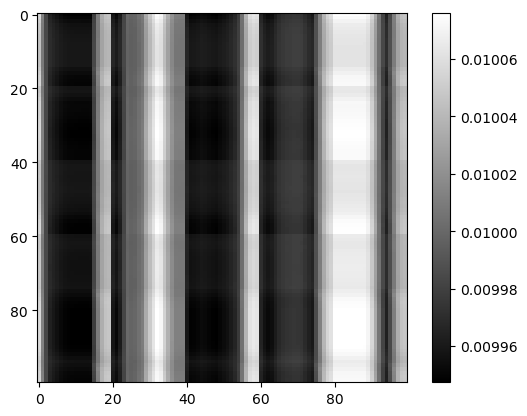

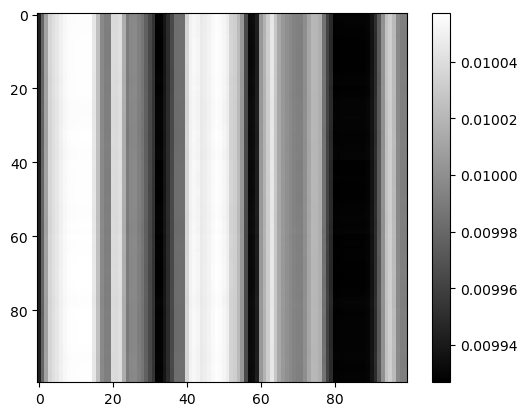

,train rmse,val rmse,test rmse
LSTM_3_1_1_3_0.0001,570.062317,541.402222,525.756653
LSTM_3_1_2_3_0.0001,572.156128,543.793579,528.342896
LSTM_3_2_1_3_0.0001,572.627563,544.317383,528.816223
LSTM_3_2_2_3_0.0001,552.991333,511.032898,500.488037


epoch: 1000, patience = 10, rnn1 = LSTM, hid1 = 5


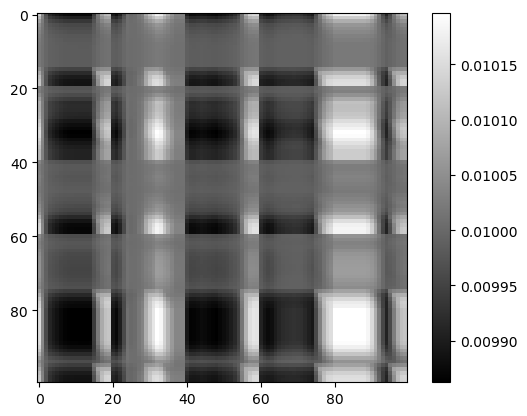

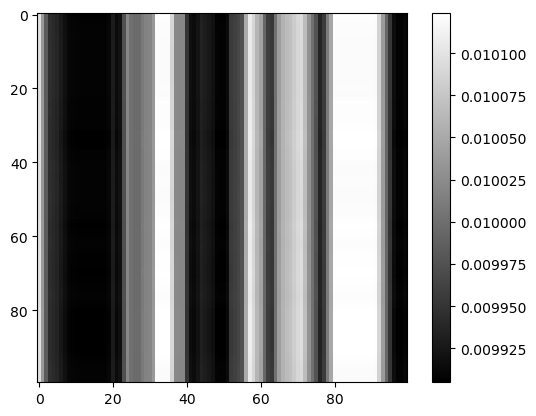

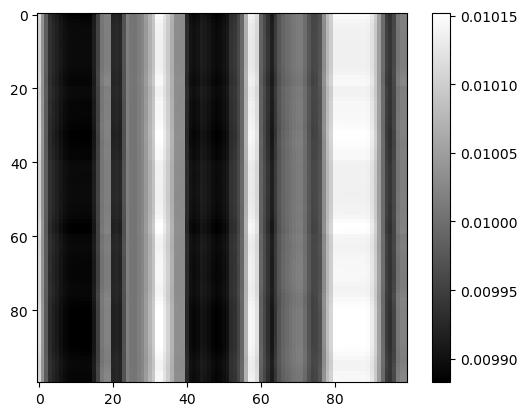

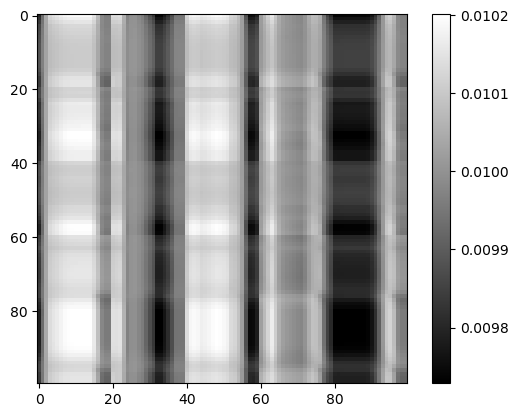

,train rmse,val rmse,test rmse
LSTM_5_1_1_3_0.0001,572.285522,543.935913,528.429382
LSTM_5_1_2_3_0.0001,337.363525,287.853027,287.024109
LSTM_5_2_1_3_0.0001,562.107666,519.902100,508.113037
LSTM_5_2_2_3_0.0001,556.644043,514.644043,503.895508


epoch: 1000, patience = 10, rnn1 = LSTM, hid1 = 7


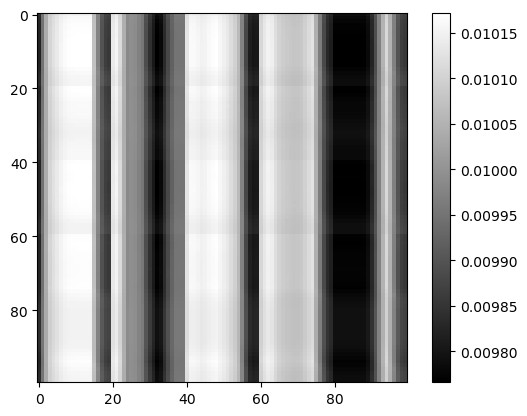

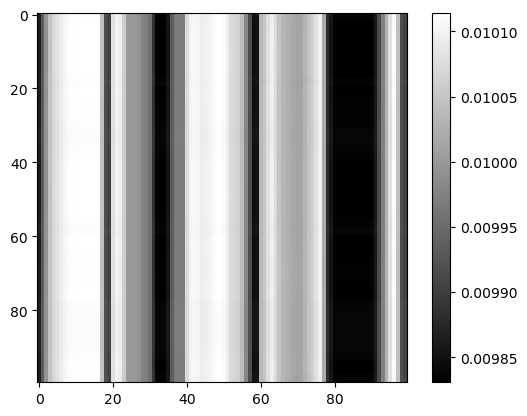

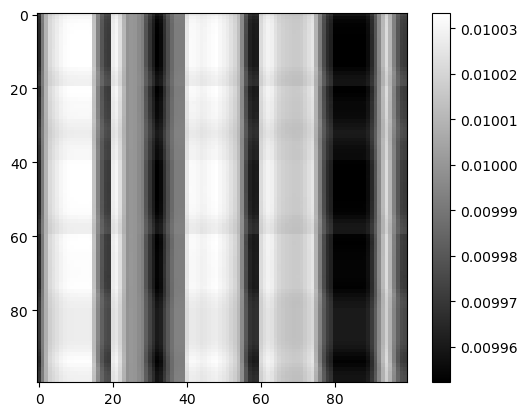

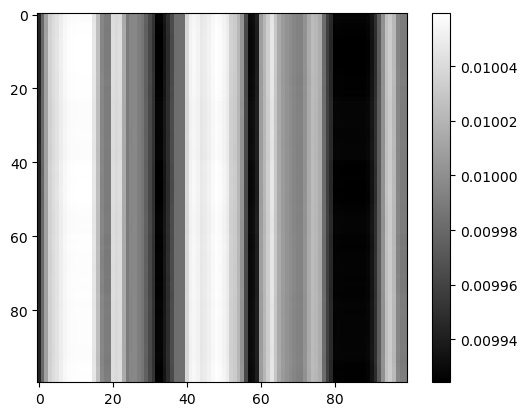

,train rmse,val rmse,test rmse
LSTM_7_1_1_3_0.0001,571.985596,543.519470,527.943542
LSTM_7_1_2_3_0.0001,278.982025,195.504913,208.554916
LSTM_7_2_1_3_0.0001,572.233948,543.857544,528.355652
LSTM_7_2_2_3_0.0001,559.098206,517.045654,506.431763


epoch: 1000, patience = 10, rnn1 = GRU, hid1 = 3


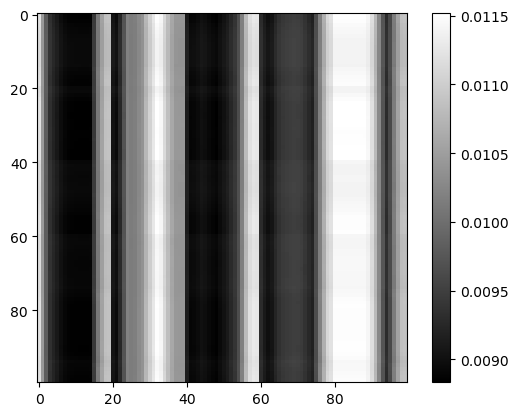

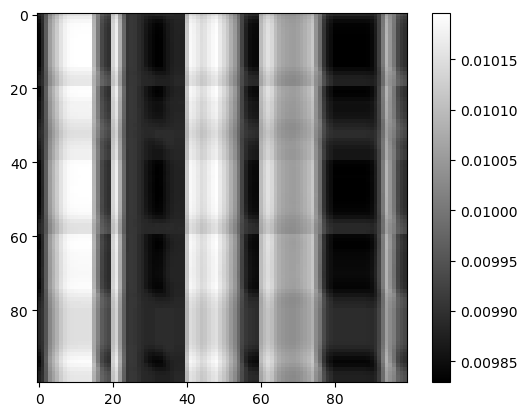

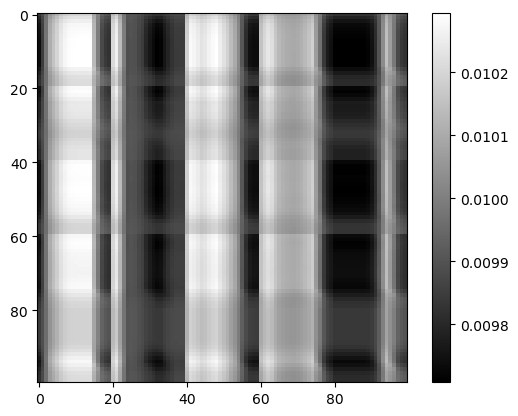

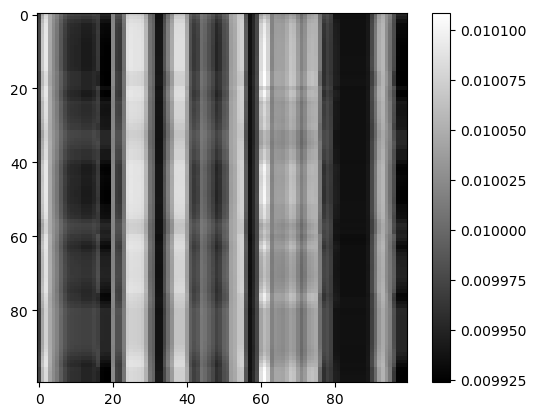

,train rmse,val rmse,test rmse
GRU_3_1_1_3_0.0001,572.032898,543.581787,528.009583
GRU_3_1_2_3_0.0001,572.587097,544.301880,528.800110
GRU_3_2_1_3_0.0001,572.013245,543.688904,528.191833
GRU_3_2_2_3_0.0001,321.876251,225.795578,237.759262


epoch: 1000, patience = 10, rnn1 = GRU, hid1 = 5


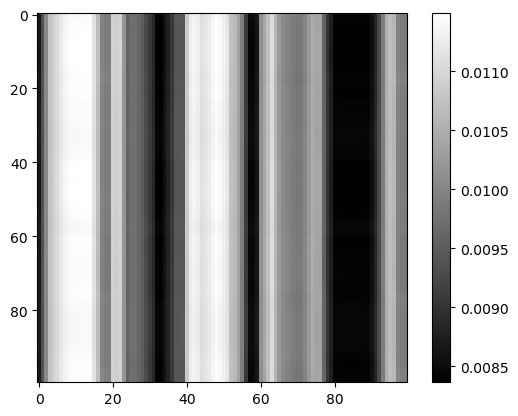

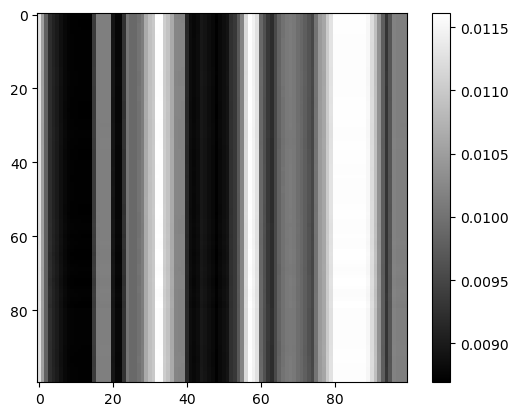

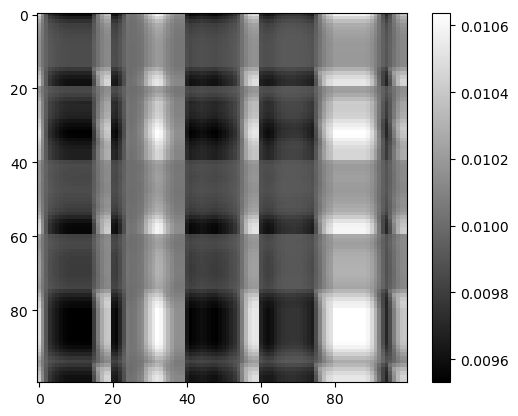

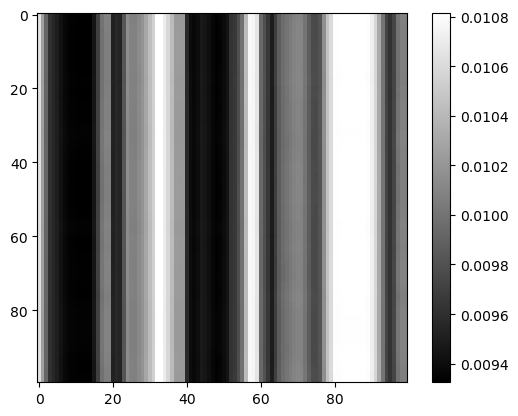

,train rmse,val rmse,test rmse
GRU_5_1_1_3_0.0001,560.928894,519.512939,510.739563
GRU_5_1_2_3_0.0001,330.557312,248.612869,250.522995
GRU_5_2_1_3_0.0001,571.947998,543.502563,528.047485
GRU_5_2_2_3_0.0001,560.750122,518.795044,507.484467


epoch: 1000, patience = 10, rnn1 = GRU, hid1 = 7


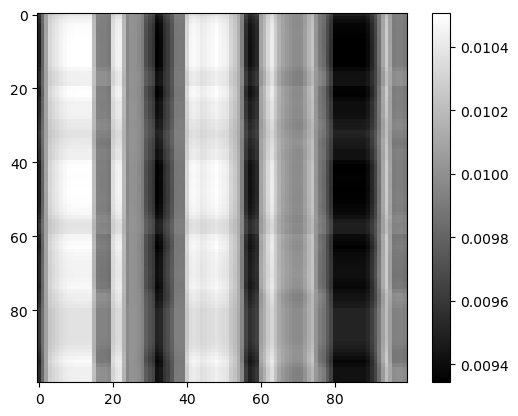

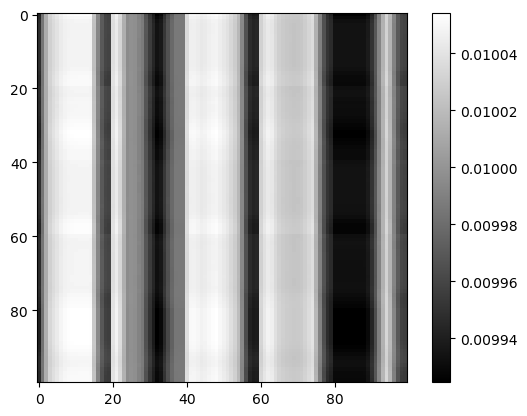

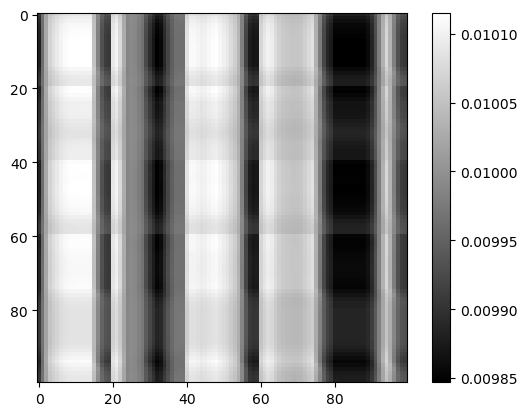

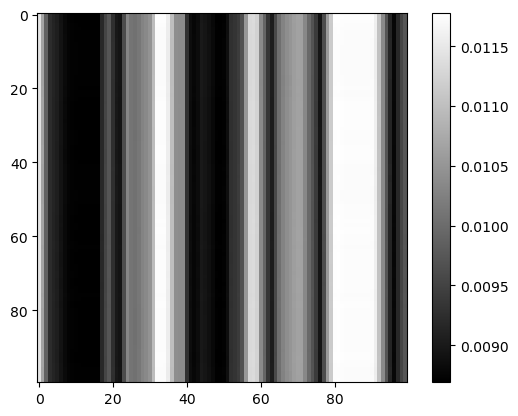

,train rmse,val rmse,test rmse
GRU_7_1_1_3_0.0001,553.410034,513.334229,502.748779
GRU_7_1_2_3_0.0001,571.374512,542.871460,527.255676
GRU_7_2_1_3_0.0001,572.112671,543.771851,528.283936
GRU_7_2_2_3_0.0001,297.073730,207.110931,171.439911


epoch: 1000, patience = 10, rnn1 = RNN, hid1 = 3


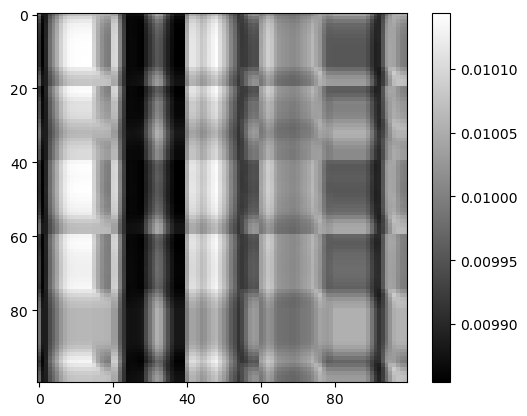

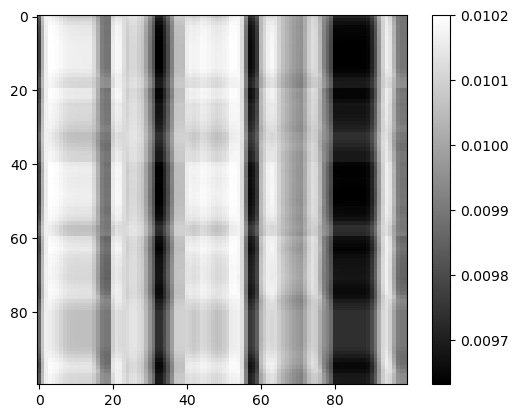

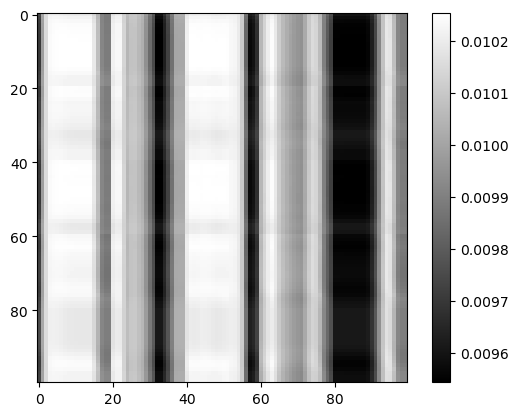

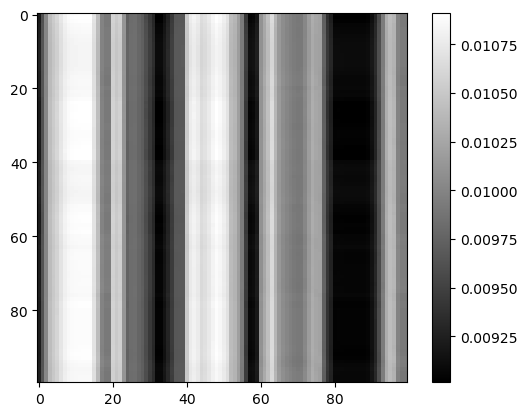

,train rmse,val rmse,test rmse
RNN_3_1_1_3_0.0001,572.155334,543.806946,528.322754
RNN_3_1_2_3_0.0001,552.394592,509.364258,500.460388
RNN_3_2_1_3_0.0001,560.585449,518.460205,508.587524
RNN_3_2_2_3_0.0001,559.104797,515.946960,504.408264


epoch: 1000, patience = 10, rnn1 = RNN, hid1 = 5


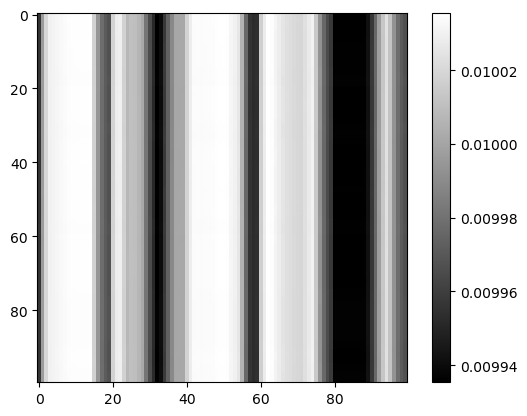

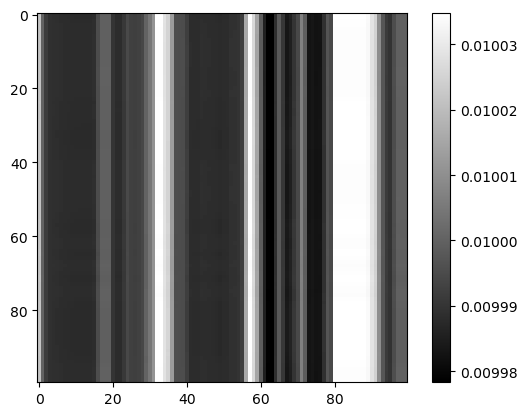

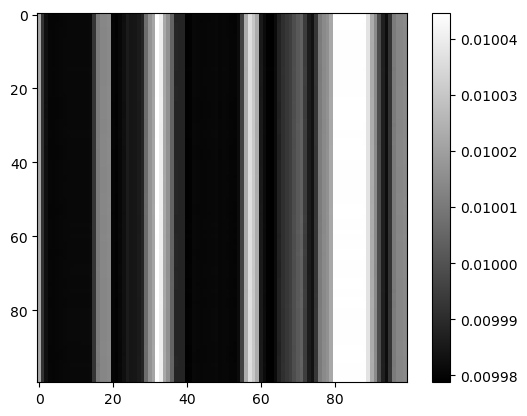

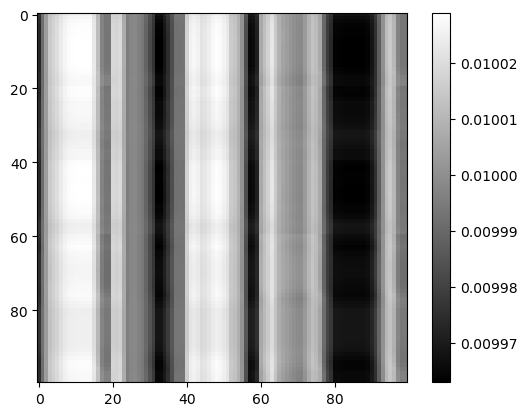

,train rmse,val rmse,test rmse
RNN_5_1_1_3_0.0001,571.646851,543.281677,527.855835
RNN_5_1_2_3_0.0001,574.790527,541.514648,521.995850
RNN_5_2_1_3_0.0001,557.437805,517.304626,504.808044
RNN_5_2_2_3_0.0001,559.247131,516.457397,505.225952


epoch: 1000, patience = 10, rnn1 = RNN, hid1 = 7


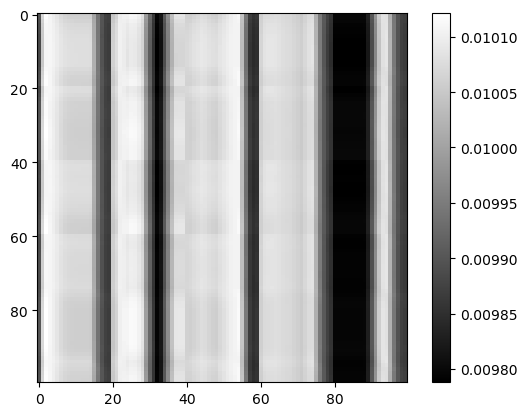

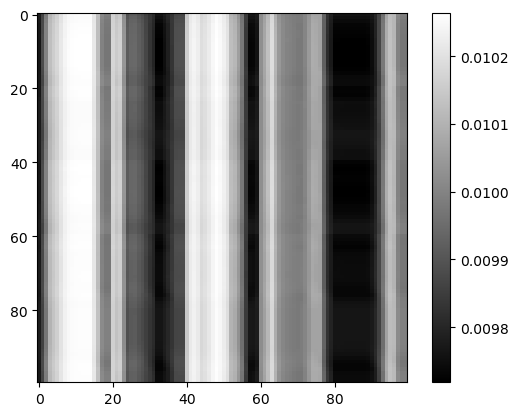

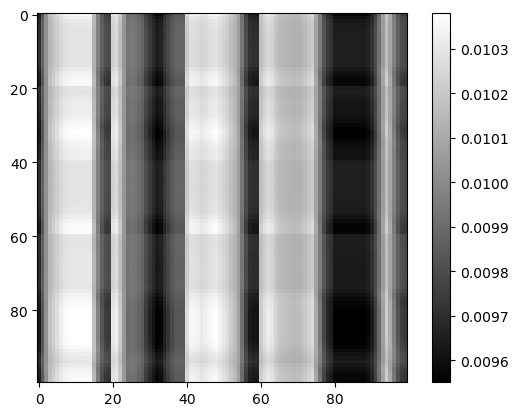

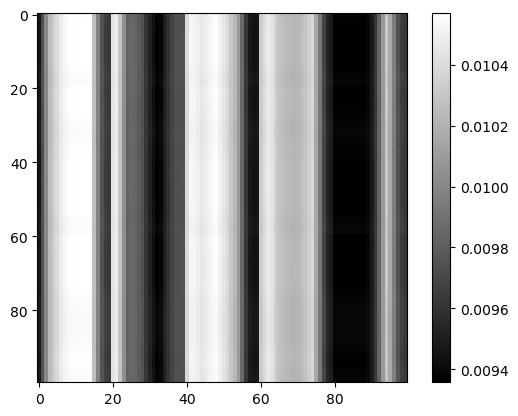

,train rmse,val rmse,test rmse
RNN_7_1_1_3_0.0001,572.876953,544.571167,529.097778
RNN_7_1_2_3_0.0001,562.484253,520.418213,509.740295
RNN_7_2_1_3_0.0001,572.373535,544.005798,528.546143
RNN_7_2_2_3_0.0001,571.960022,543.458374,527.837769


epoch: 2000, patience = 20, rnn1 = LSTM, hid1 = 3


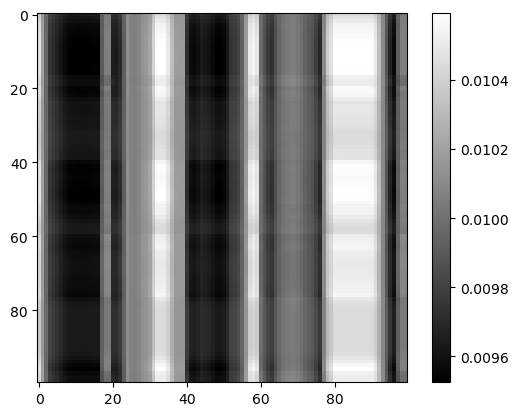

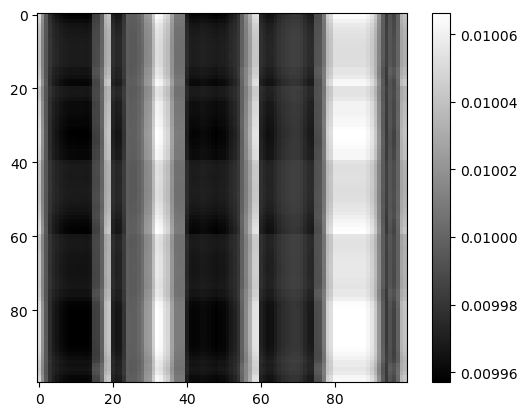

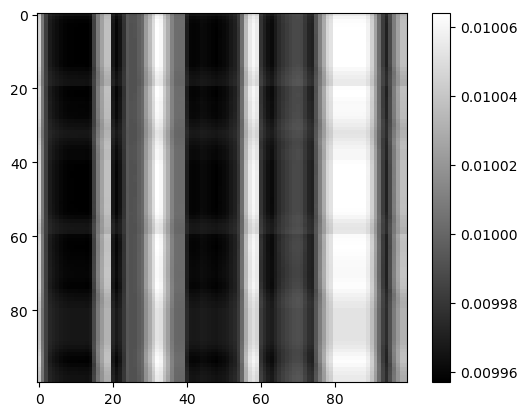

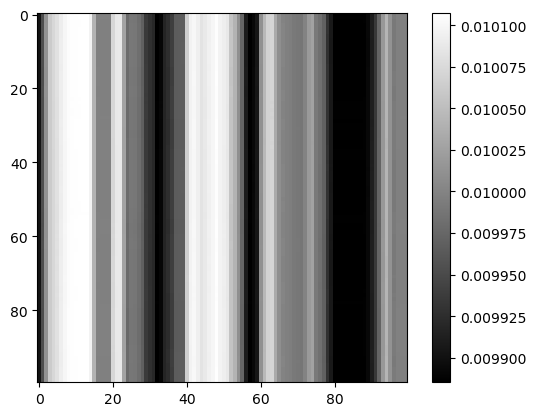

,train rmse,val rmse,test rmse
LSTM_3_1_1_3_0.0001,298.346924,239.673874,252.571014
LSTM_3_1_2_3_0.0001,571.111206,538.239868,527.437134
LSTM_3_2_1_3_0.0001,573.155457,535.283630,523.907654
LSTM_3_2_2_3_0.0001,319.839905,199.495148,210.435181


epoch: 2000, patience = 20, rnn1 = LSTM, hid1 = 5


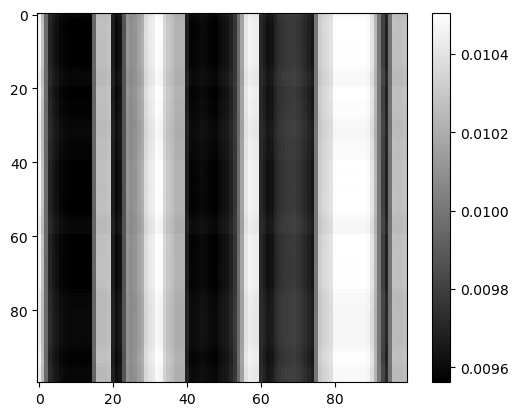

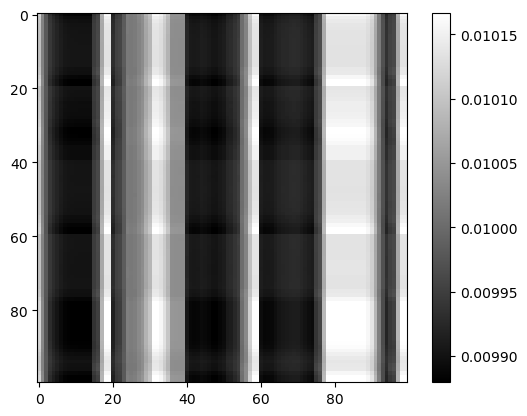

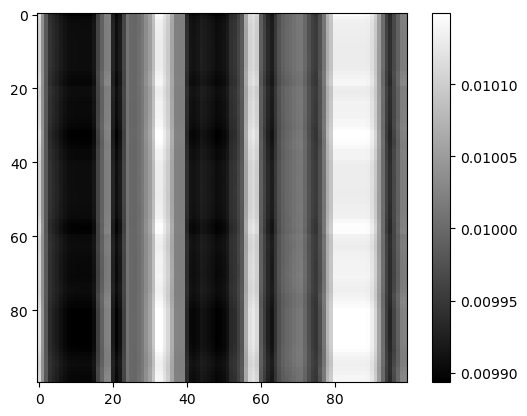

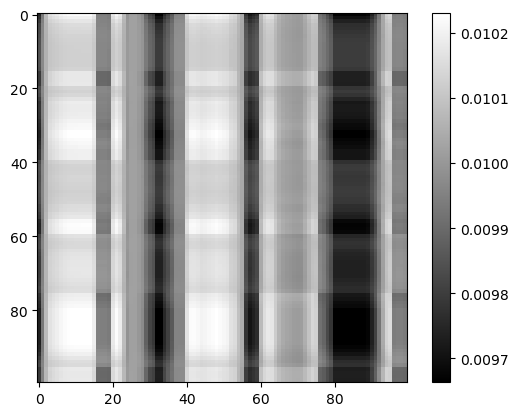

,train rmse,val rmse,test rmse
LSTM_5_1_1_3_0.0001,276.408051,172.454575,244.304626
LSTM_5_1_2_3_0.0001,280.701172,175.006775,205.086029
LSTM_5_2_1_3_0.0001,240.520309,168.830307,189.193192
LSTM_5_2_2_3_0.0001,299.564331,225.415863,220.711655


epoch: 2000, patience = 20, rnn1 = LSTM, hid1 = 7


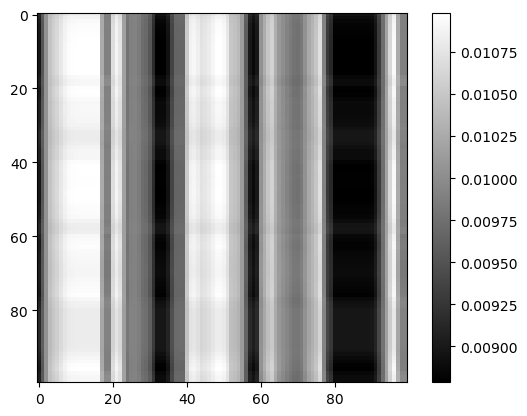

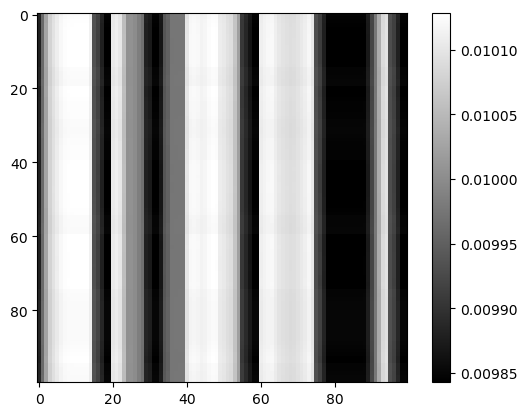

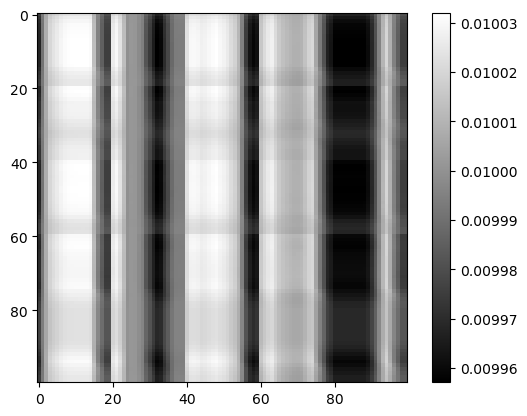

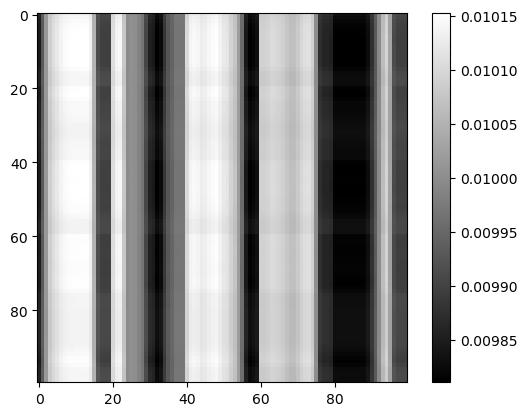

,train rmse,val rmse,test rmse
LSTM_7_1_1_3_0.0001,287.710693,210.885498,231.044373
LSTM_7_1_2_3_0.0001,278.982025,195.504913,208.554916
LSTM_7_2_1_3_0.0001,573.454895,535.610901,524.229919
LSTM_7_2_2_3_0.0001,273.564697,180.857010,206.864105


epoch: 2000, patience = 20, rnn1 = GRU, hid1 = 3


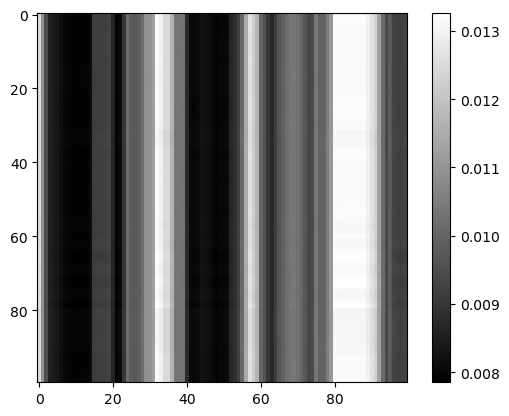

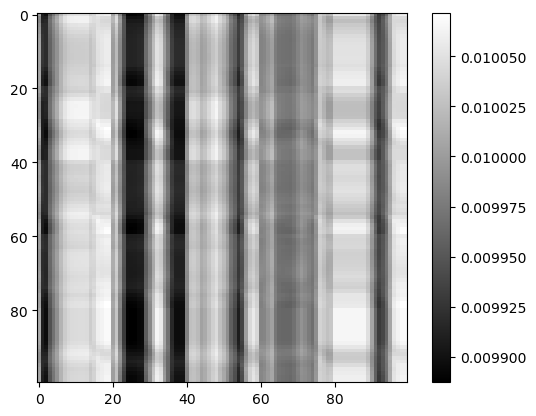

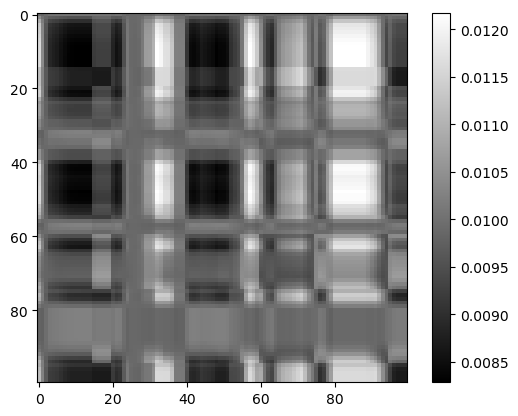

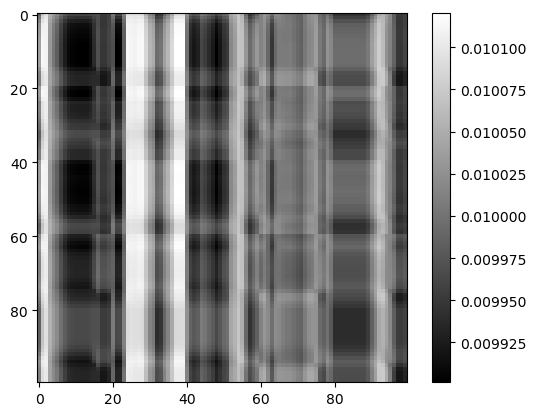

,train rmse,val rmse,test rmse
GRU_3_1_1_3_0.0001,308.192383,192.505615,194.420517
GRU_3_1_2_3_0.0001,575.459778,537.747314,526.298523
GRU_3_2_1_3_0.0001,258.185944,171.836823,131.875229
GRU_3_2_2_3_0.0001,248.173950,184.242035,223.341980


epoch: 2000, patience = 20, rnn1 = GRU, hid1 = 5


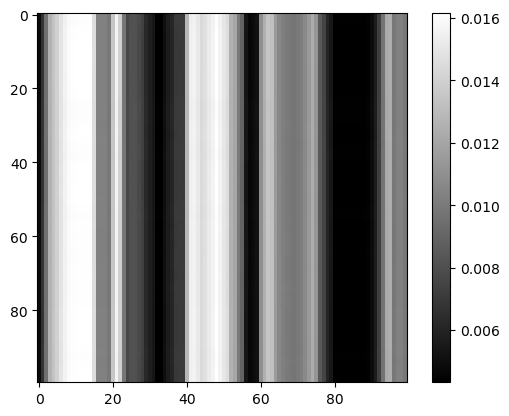

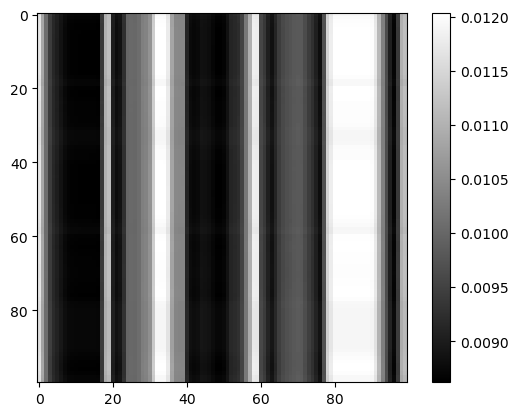

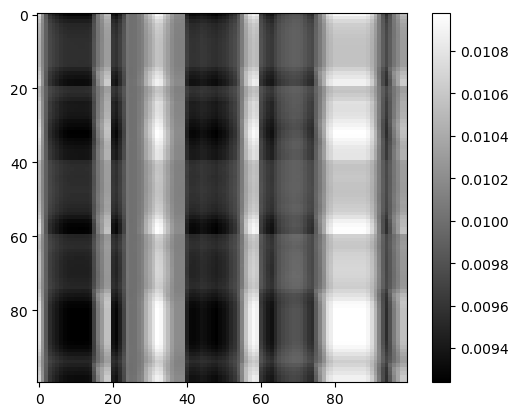

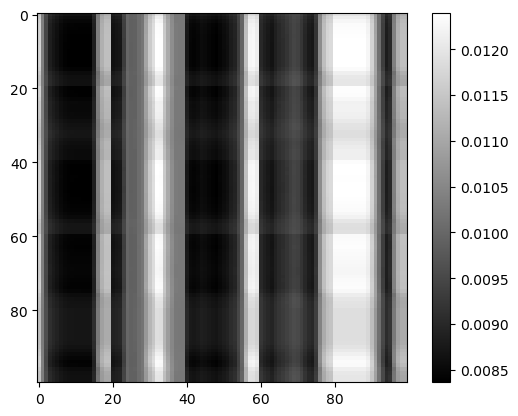

,train rmse,val rmse,test rmse
GRU_5_1_1_3_0.0001,325.282867,246.653412,286.469482
GRU_5_1_2_3_0.0001,316.794373,202.936615,166.822388
GRU_5_2_1_3_0.0001,573.827271,536.119751,524.696777
GRU_5_2_2_3_0.0001,254.858124,154.938049,136.233597


epoch: 2000, patience = 20, rnn1 = GRU, hid1 = 7


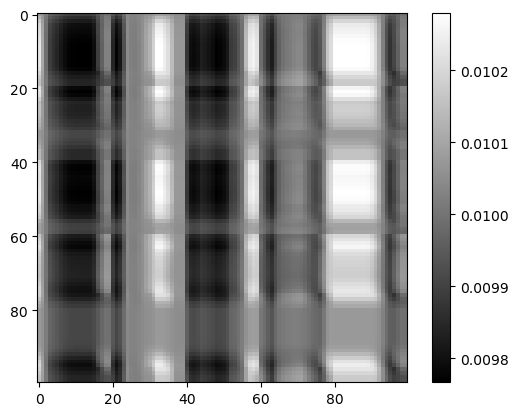

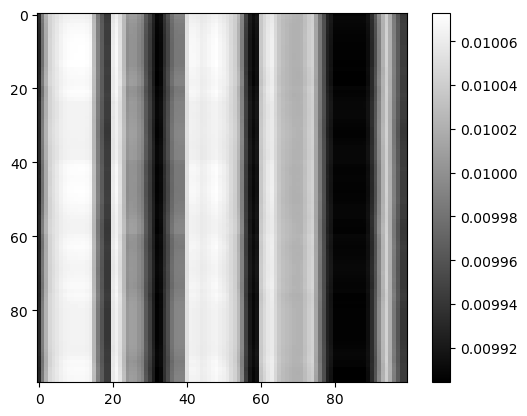

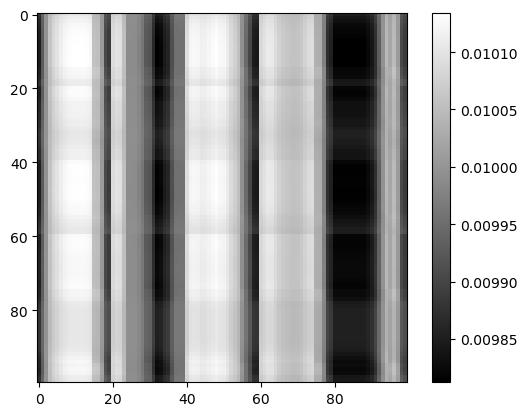

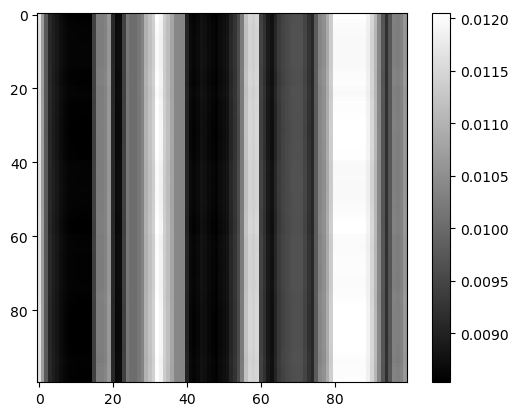

,train rmse,val rmse,test rmse
GRU_7_1_1_3_0.0001,242.358810,179.807617,200.067642
GRU_7_1_2_3_0.0001,567.496216,529.329712,517.805542
GRU_7_2_1_3_0.0001,571.090149,538.221436,527.415588
GRU_7_2_2_3_0.0001,277.081970,173.616089,151.587448


epoch: 2000, patience = 20, rnn1 = RNN, hid1 = 3


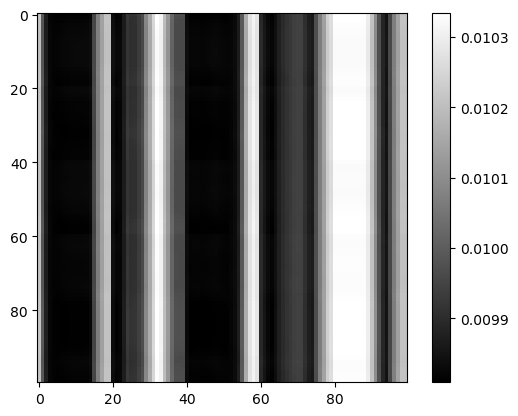

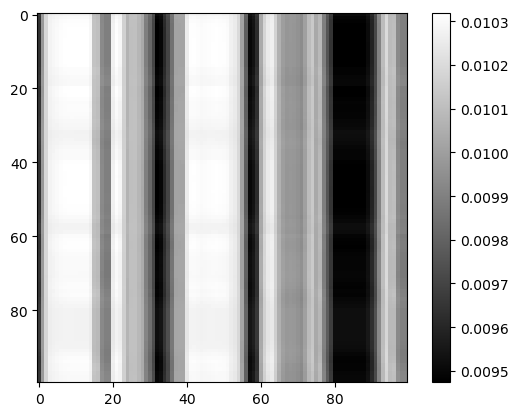

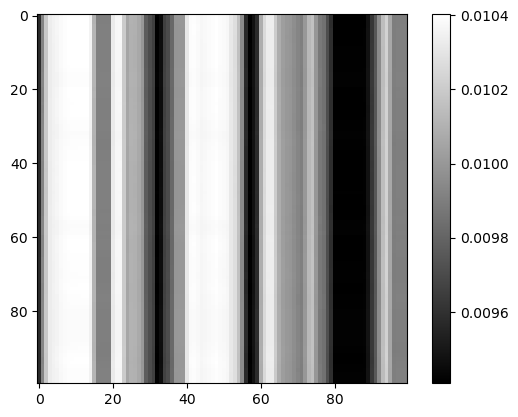

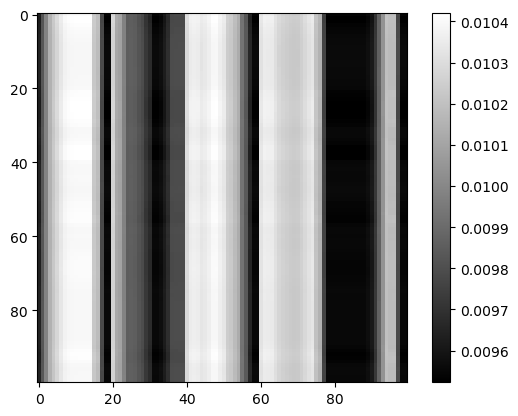

,train rmse,val rmse,test rmse
RNN_3_1_1_3_0.0001,574.599792,536.888550,525.524414
RNN_3_1_2_3_0.0001,283.321350,200.929596,185.416229
RNN_3_2_1_3_0.0001,288.763885,195.048996,190.719070
RNN_3_2_2_3_0.0001,302.397736,196.480560,166.965363


epoch: 2000, patience = 20, rnn1 = RNN, hid1 = 5


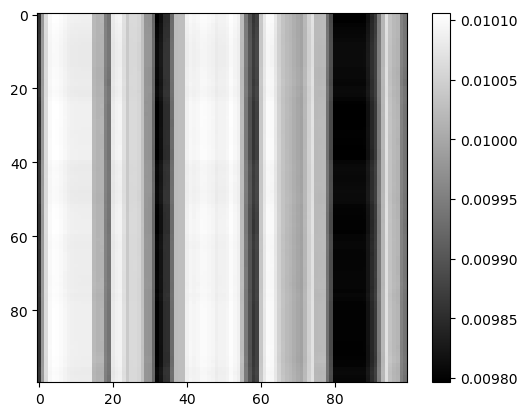

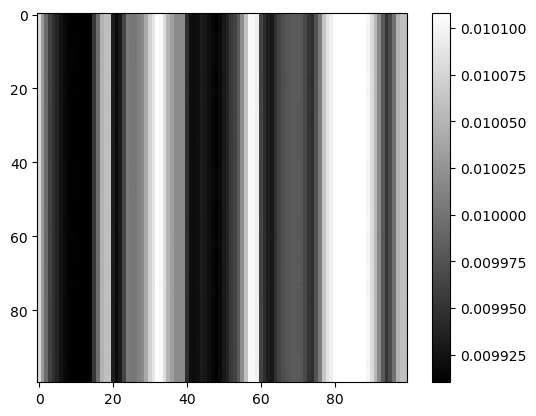

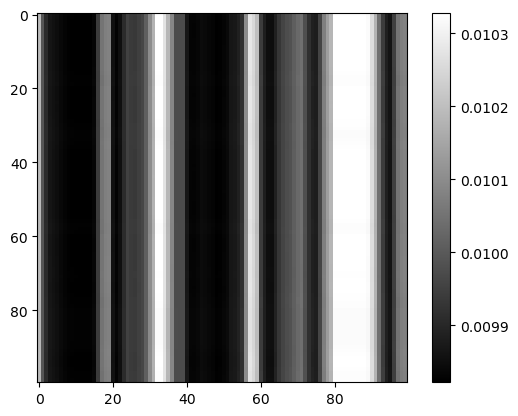

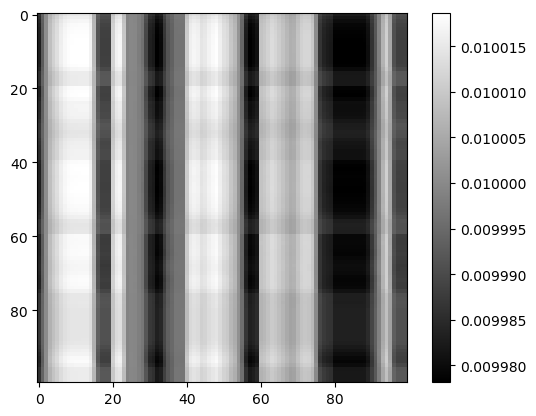

,train rmse,val rmse,test rmse
RNN_5_1_1_3_0.0001,292.104248,209.332611,213.401154
RNN_5_1_2_3_0.0001,290.441101,196.518173,177.148209
RNN_5_2_1_3_0.0001,280.538391,190.894379,178.995682
RNN_5_2_2_3_0.0001,272.260315,211.159729,199.888077


epoch: 2000, patience = 20, rnn1 = RNN, hid1 = 7


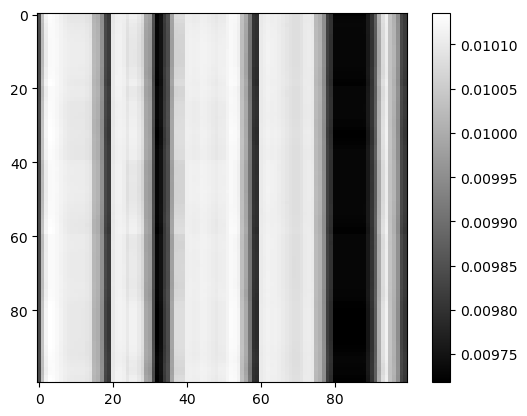

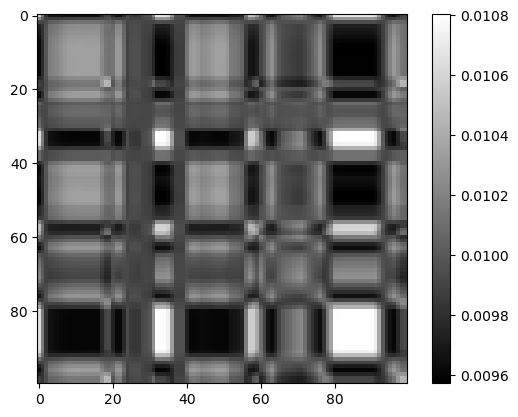

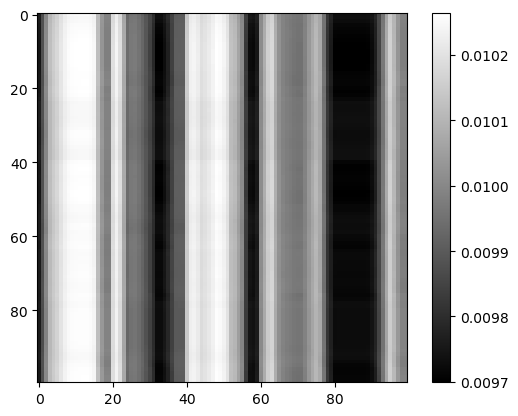

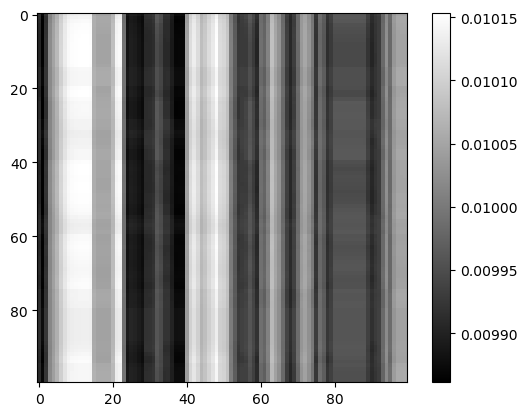

,train rmse,val rmse,test rmse
RNN_7_1_1_3_0.0001,571.824524,539.007935,528.202759
RNN_7_1_2_3_0.0001,262.498413,170.851074,148.490768
RNN_7_2_1_3_0.0001,359.844727,264.839478,282.331696
RNN_7_2_2_3_0.0001,265.899353,185.182892,204.493088


epoch: 3000, patience = 500, rnn1 = LSTM, hid1 = 3


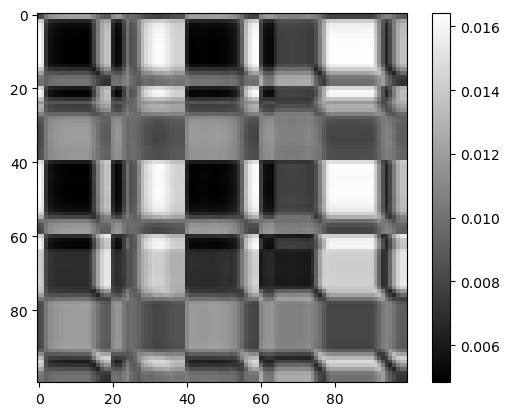

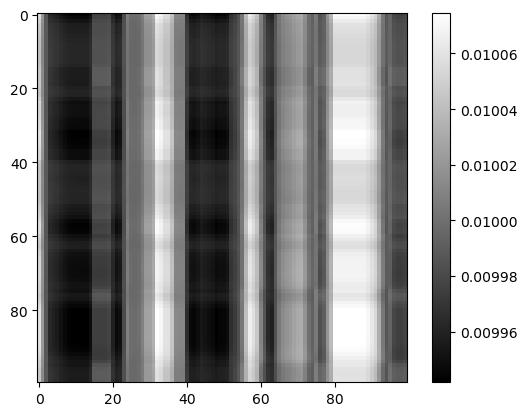

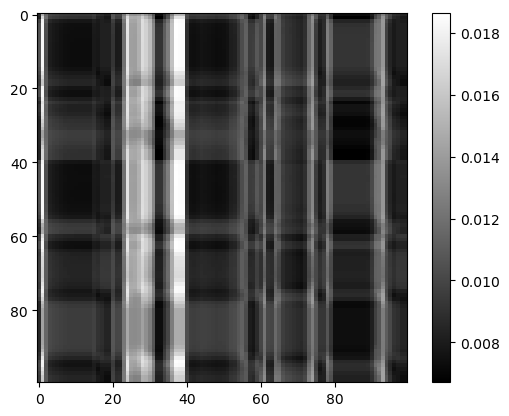

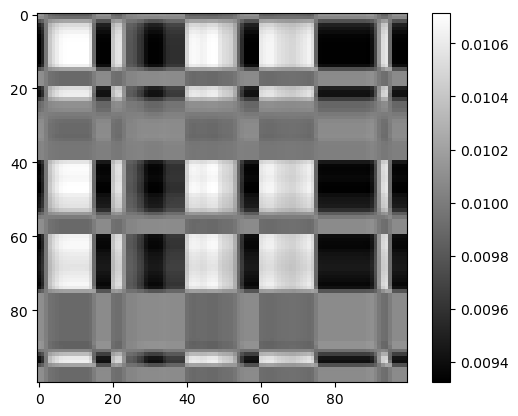

,train rmse,val rmse,test rmse
LSTM_3_1_1_3_0.0001,153.108368,96.933403,93.348732
LSTM_3_1_2_3_0.0001,573.812012,526.519714,521.695984
LSTM_3_2_1_3_0.0001,173.351318,92.255692,106.671593
LSTM_3_2_2_3_0.0001,164.378143,90.720299,103.434982


epoch: 3000, patience = 500, rnn1 = LSTM, hid1 = 5


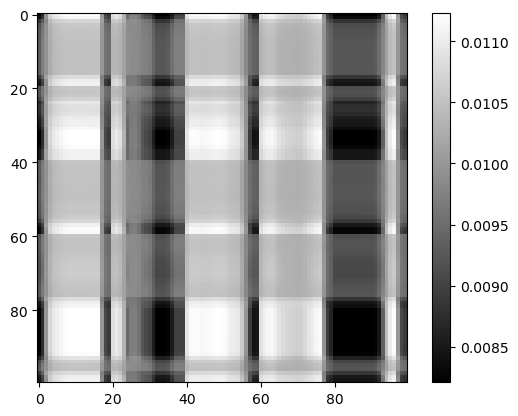

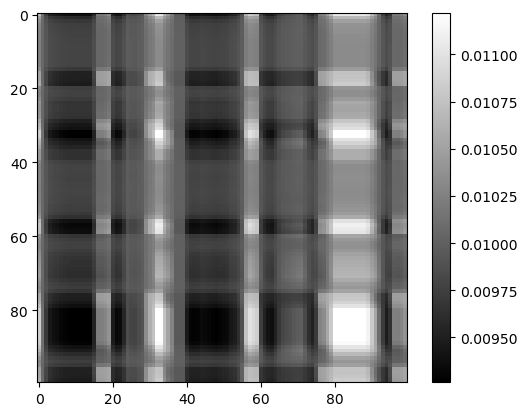

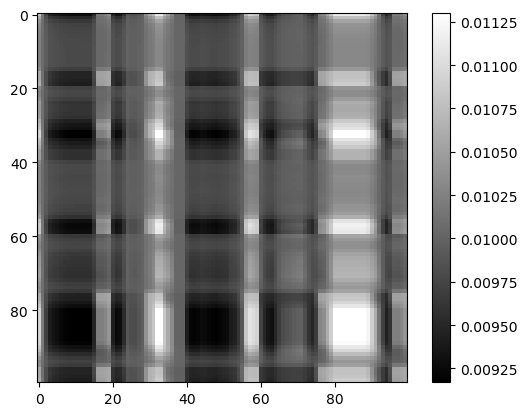

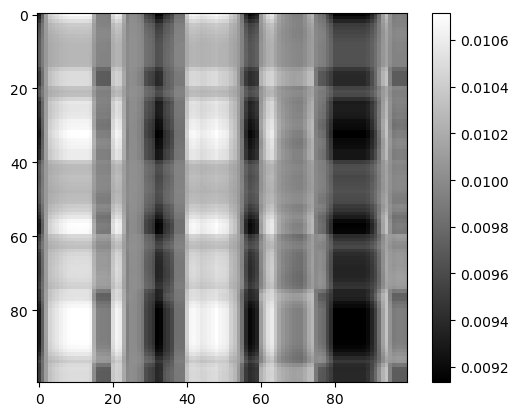

,train rmse,val rmse,test rmse
LSTM_5_1_1_3_0.0001,163.908737,84.632751,122.502518
LSTM_5_1_2_3_0.0001,213.707092,113.508453,102.453568
LSTM_5_2_1_3_0.0001,214.127060,110.331566,106.709114
LSTM_5_2_2_3_0.0001,207.057388,124.544258,131.147095


epoch: 3000, patience = 500, rnn1 = LSTM, hid1 = 7


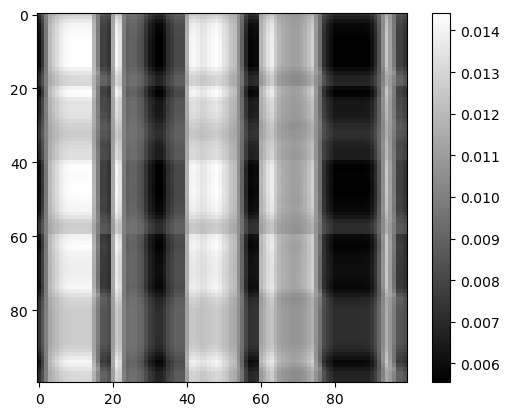

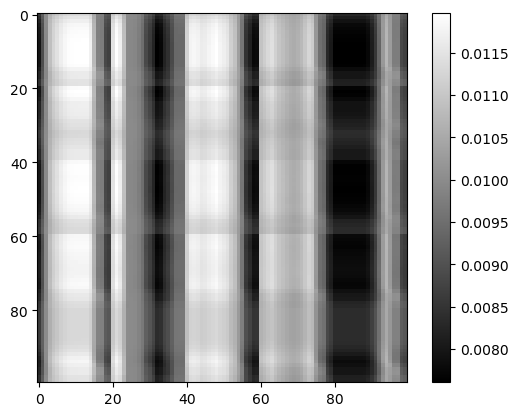

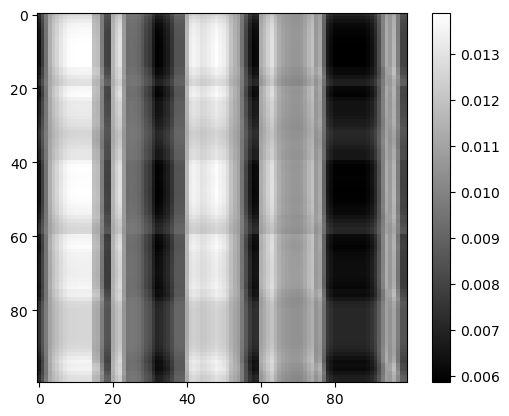

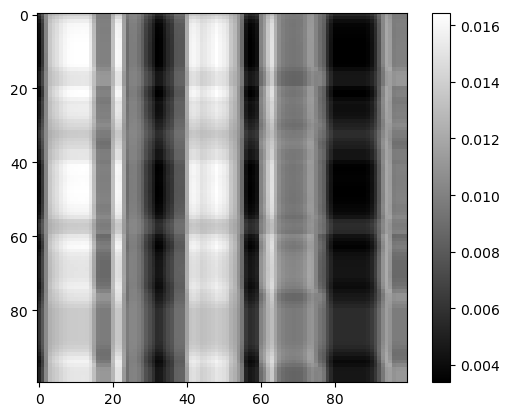

,train rmse,val rmse,test rmse
LSTM_7_1_1_3_0.0001,217.043457,121.676933,114.923218
LSTM_7_1_2_3_0.0001,268.831085,115.035950,160.785629
LSTM_7_2_1_3_0.0001,197.353607,125.254013,148.023804
LSTM_7_2_2_3_0.0001,146.465103,91.844025,92.595558


epoch: 3000, patience = 500, rnn1 = GRU, hid1 = 3


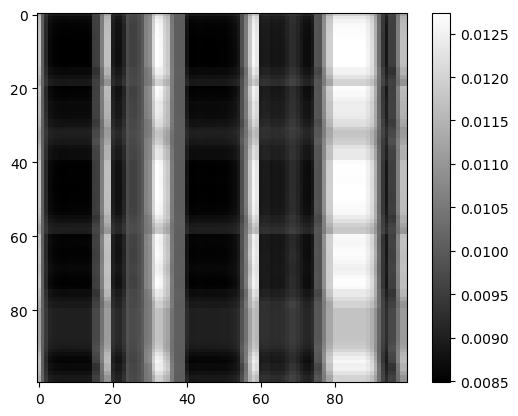

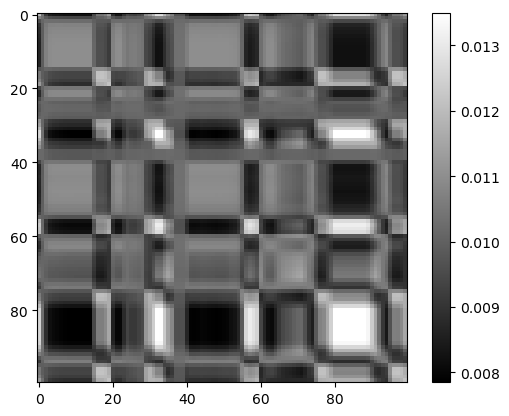

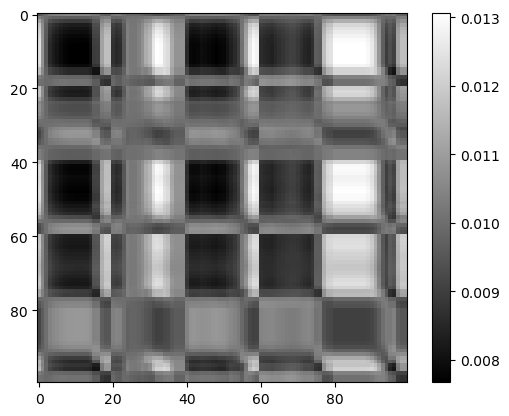

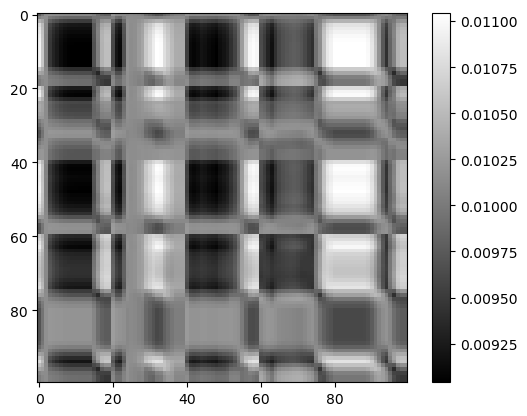

,train rmse,val rmse,test rmse
GRU_3_1_1_3_0.0001,200.632629,110.190025,91.808601
GRU_3_1_2_3_0.0001,207.741684,98.661446,99.010063
GRU_3_2_1_3_0.0001,194.588943,125.470589,107.425629
GRU_3_2_2_3_0.0001,252.456512,115.733719,92.318680


epoch: 3000, patience = 500, rnn1 = GRU, hid1 = 5


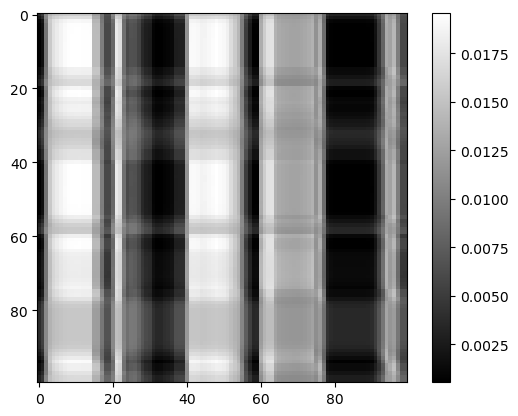

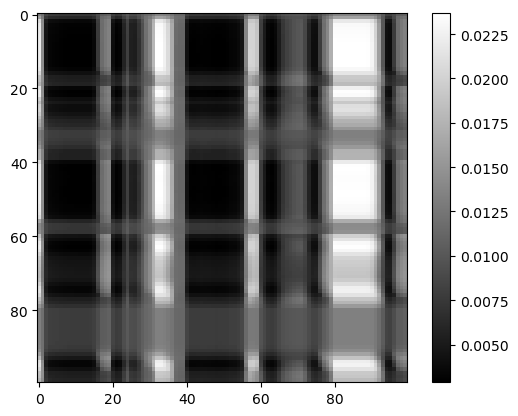

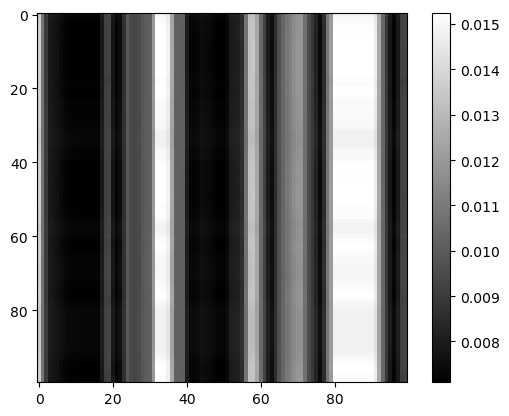

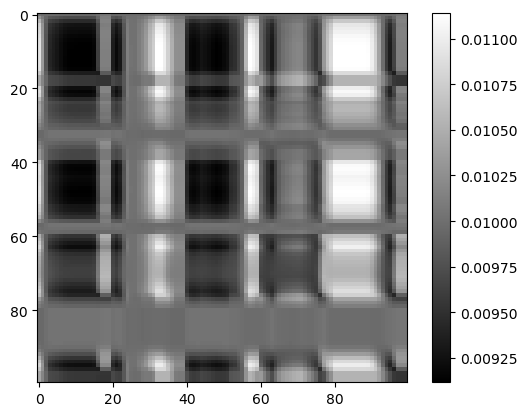

,train rmse,val rmse,test rmse
GRU_5_1_1_3_0.0001,119.497269,110.739716,61.383636
GRU_5_1_2_3_0.0001,140.445663,95.158554,70.780312
GRU_5_2_1_3_0.0001,257.016510,132.102905,118.984909
GRU_5_2_2_3_0.0001,177.534286,105.667976,84.023880


epoch: 3000, patience = 500, rnn1 = GRU, hid1 = 7


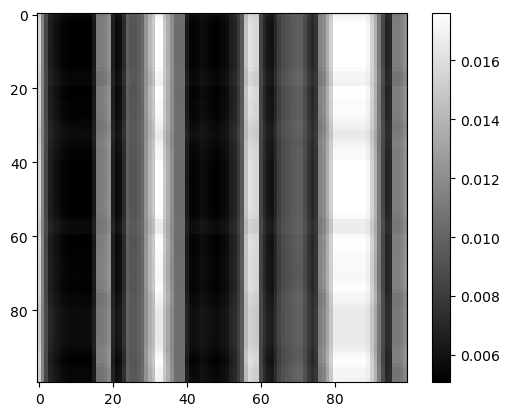

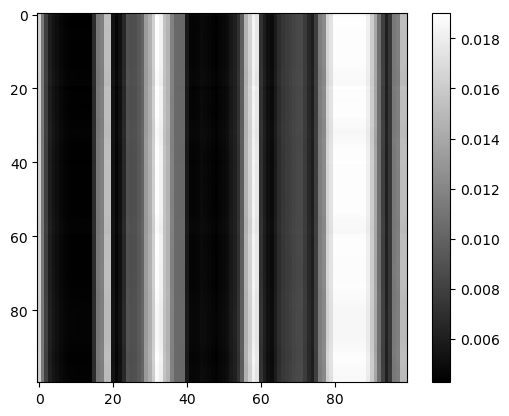

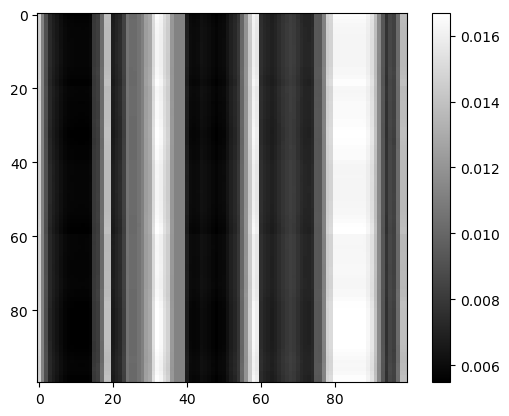

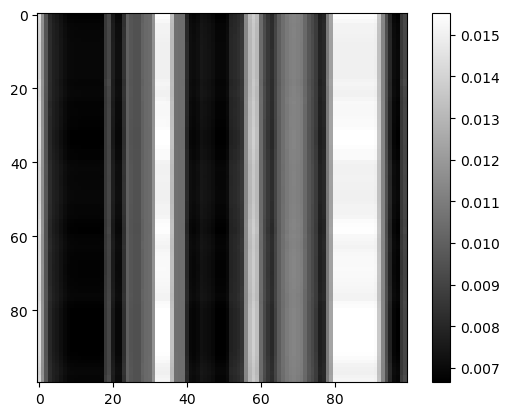

,train rmse,val rmse,test rmse
GRU_7_1_1_3_0.0001,210.502777,123.127724,118.543762
GRU_7_1_2_3_0.0001,147.337234,96.812439,96.325058
GRU_7_2_1_3_0.0001,188.094788,112.548828,136.261215
GRU_7_2_2_3_0.0001,218.110413,111.501999,114.033890


epoch: 3000, patience = 500, rnn1 = RNN, hid1 = 3


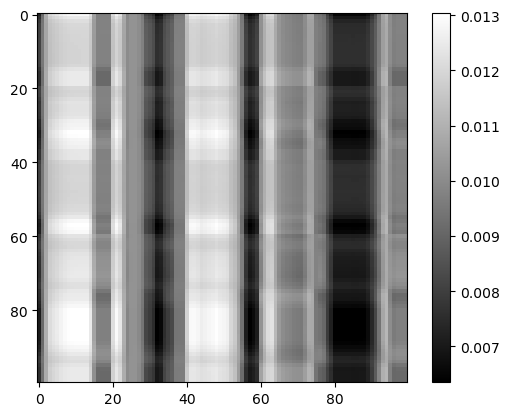

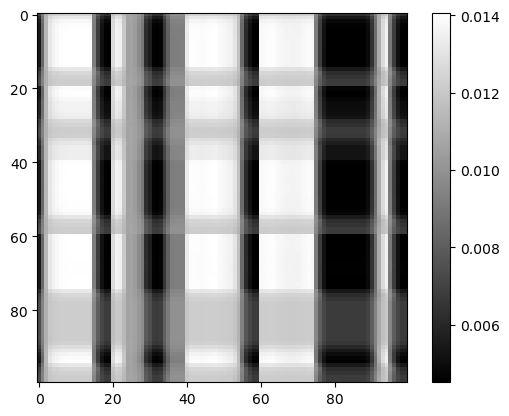

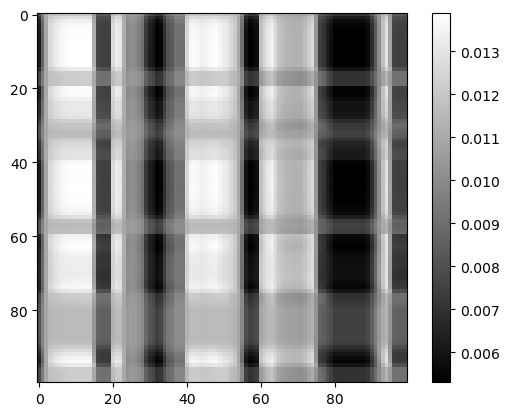

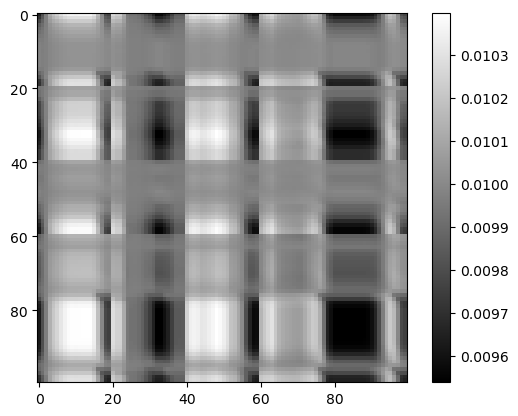

,train rmse,val rmse,test rmse
RNN_3_1_1_3_0.0001,201.873154,107.791168,127.054436
RNN_3_1_2_3_0.0001,177.866623,103.578918,95.791115
RNN_3_2_1_3_0.0001,230.942078,121.271011,132.150620
RNN_3_2_2_3_0.0001,250.211914,138.691925,222.159241


epoch: 3000, patience = 500, rnn1 = RNN, hid1 = 5


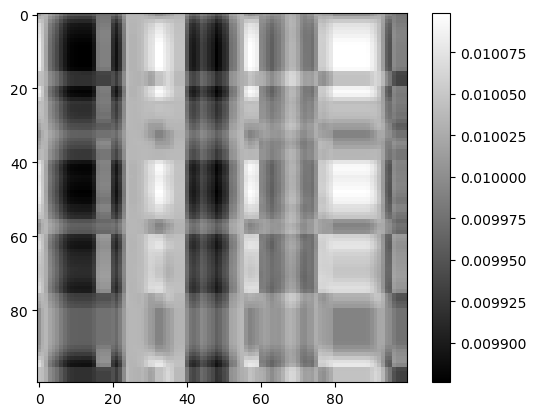

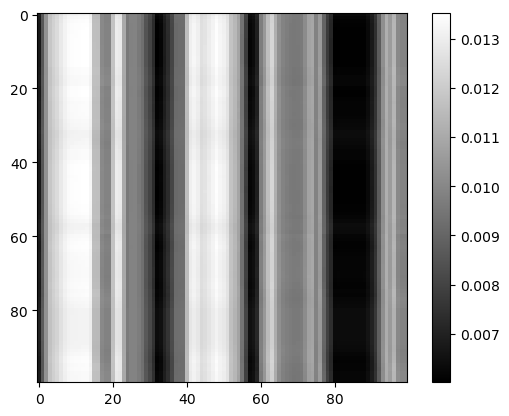

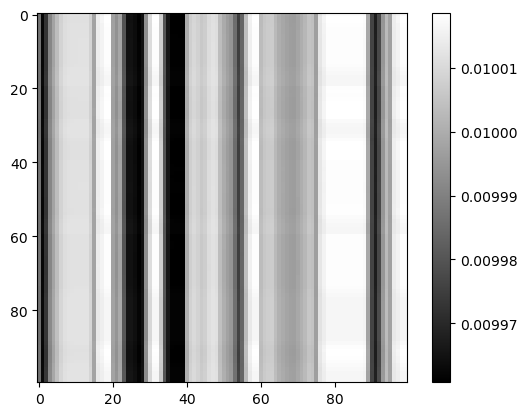

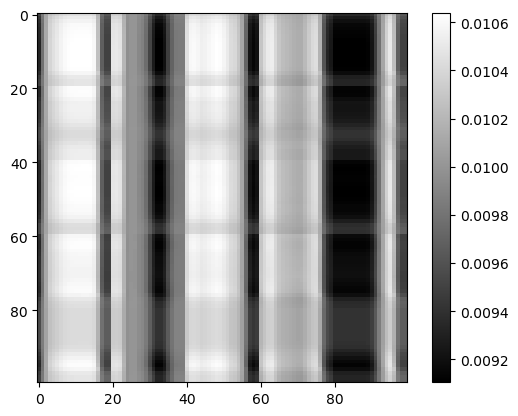

,train rmse,val rmse,test rmse
RNN_5_1_1_3_0.0001,265.535828,151.593018,138.623184
RNN_5_1_2_3_0.0001,257.287842,145.664413,148.773468
RNN_5_2_1_3_0.0001,266.111084,153.790863,151.135956
RNN_5_2_2_3_0.0001,259.306244,138.265930,143.652359


epoch: 3000, patience = 500, rnn1 = RNN, hid1 = 7


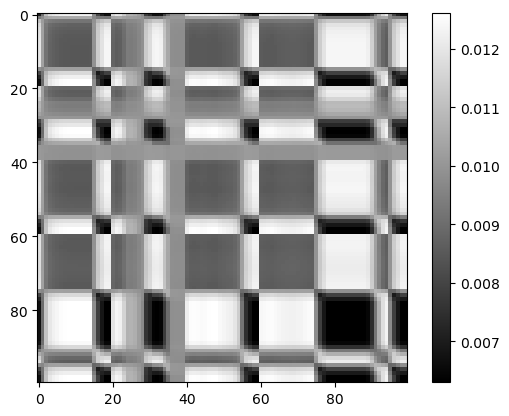

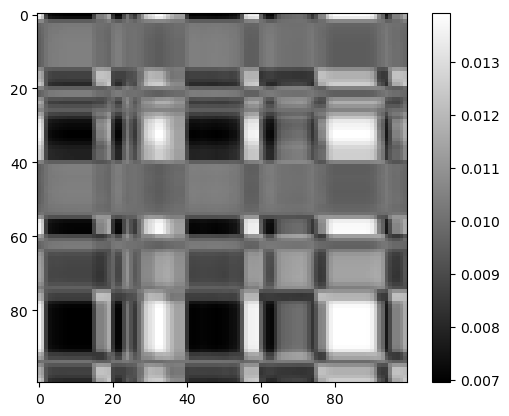

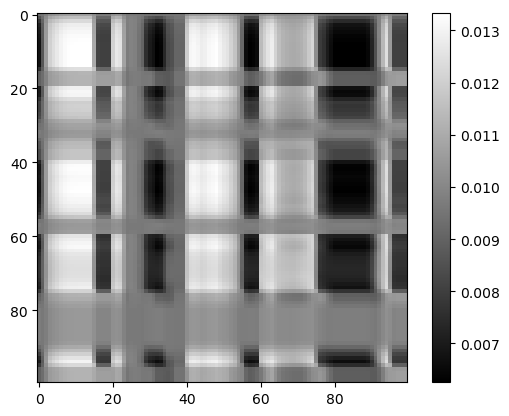

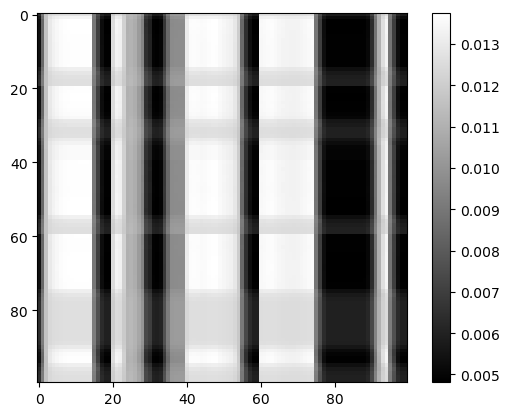

,train rmse,val rmse,test rmse
RNN_7_1_1_3_0.0001,232.734268,131.332306,142.961044
RNN_7_1_2_3_0.0001,214.401962,109.048302,94.707832
RNN_7_2_1_3_0.0001,214.712723,104.830292,121.353348
RNN_7_2_2_3_0.0001,160.166458,117.450439,91.363602


In [15]:
epochs = np.linspace(50, 1000, 20)
n_ep = int(epochs[-1])
# n_ep = 2

modelname = 'RNN_TA_CA_1DCNN'
rnns = ['LSTM', 'GRU', 'RNN']
hids = [3, 5, 7]
num_time = 120
num_cycles = 100
ep_pats = [[1000, 10], [2000, 20], [3000, 500]]
lrs = [1e-4, 1e-3, 1e-2]

num_fils = [3, 5, 7]
pools = [1, 2]
npools = [1, 2]
fsize2 = 3
psize2 = 2
mids = [8, 4, 1]

for [n_ep, patience] in ep_pats:
    for rnn1, hid1 in itertools.product(rnns, hids):
        print(f"epoch: {n_ep}, patience = {patience}, rnn1 = {rnn1}, hid1 = {hid1}")
        df = pd.DataFrame(columns = ['train rmse', 'val rmse', 'test rmse'])
        bi1 = False
        nh2 = 1
        if rnn1.startswith('Bi'):
            bi1 = True
        for pool2, npool2 in itertools.product(pools, npools):
            for fil2, lr in itertools.product(num_fils, lrs):
                history_add, state_dict_add, ta_add, ca_add = history_state_dict_add(num_cycles, modelname, n_ep, patience,
                                                                rnn1, hid1, nh2, fil2, pool2, npool2, fsize2, psize2, lr)
                history = load_data(history_add)
                        
                df.loc[f'{rnn1}_{hid1}_{pool2}_{npool2}_{fil2}_{lr}'] = [history.iloc[-1, 0], history.iloc[-1, 1], history.iloc[-1, 2]]
                ca = load_data(ca_add)
#                 print(ca.size())
                ca = ca.mean(dim = 0).squeeze()
#                 print(ca.size())
                ca = ca.detach().cpu().numpy();
                plt.imshow(ca, cmap = cm.gray);
                plt.colorbar();
                plt.show();
                break
        df

In [ ]:
# Hyperparameters
num_vars = train_features.size()[1]

modelname = 'RNN_TA_CA_1DCNN'
rnns = ['LSTM', 'GRU', 'RNN']
hids = [3, 5, 7]
num_time = max_time
num_cycles = 100
ep_pats = [[1000, 10], [2000, 20], [3000, 500]]
lrs = [1e-4, 1e-3, 1e-2]

num_fils = [3, 5, 7]
pools = [1, 2]
npools = [1, 2]
fsize2 = 3
psize2 = 2
mids = [8, 4, 1]

import time

for [n_ep, patience] in ep_pats:
    print(f"epoch = {n_ep}, patience = {patience}")
    trdl = globals()[f'reg_train_dataloader_{num_cycles}']
    vdl = globals()[f'reg_val_dataloader_{num_cycles}']
    tedl = globals()[f'reg_test_dataloader_{num_cycles}']
    for rnn1, hid1 in itertools.product(rnns, hids):
        bi1 = False
        
        nh2 = 1
        if rnn1.startswith('Bi'):
            bi1 = True
        for pool2, npool2 in itertools.product(pools, npools):
            print(f'Pooling: {pool2} layers, Nonpooling: {npool2} layers, split by {60/max_time} min')
            for fil2, lr in itertools.product(num_fils, lrs):
                start = time.time()
                print(f"rnn = {rnn1}, bi = {bi1}, hid = {hid1}, num_heads = {nh2}, num_fil = {fil2}, lr = {lr}")
                
                # Construct CNN
                model = globals()[modelname](num_vars, num_time, num_cycles, rnn1, bi1, hid1, nh2, fil2, pool2, npool2, fsize2, psize2, mids).to(device)

                # Train
                model_train = train(model, trdl, vdl, tedl, n_ep, lr, patience, verbose = False)
                best_model, best_loss, history, ta, ca = model_train.TrainModel()

                print('best_loss = '+ str(best_loss))

                history_add, state_dict_add, ta_add, ca_add = history_state_dict_add(num_cycles, modelname, n_ep, patience,
                                                                            rnn1, hid1, nh2, fil2, pool2, npool2, fsize2, psize2, lr)
                
                # saving best_epoch, loss history, ta score
                save_data(history, history_add)
                save_data(best_model.state_dict(), state_dict_add)
                save_data(ta, ta_add)
                save_data(ca, ca_add)

                print("time: ", time.time()-start)
                print("\n\n")